* <a href="#H2B"> Analysing Michael Olma data set with the H2b fluorescent marker </a>
    * <a href="#Unnormalized"> Unnormalized H2b data set</a>
    * <a href="#Normalized">Normalized</a>
    * <a href="#MitoseOrNot">Classifier: Mitosis or not</a>

In [23]:
### All the packages we need:
%matplotlib inline
%load_ext rpy2.ipython

from Reader import Reader
from Randomforest import RandomForest_Autotunner,plot_matrix,Measure,check_rotate
from Traj_creator import Traj_data

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os.path
import cPickle as pkl


ImportError: No module named rpy2.ipython

# <a name="Unnormalized"></a> Unnormalized H2b data set

In [2]:
num_str="0015" 
## Well name
if os.path.isfile("H2b_data.csv"):
    print "The file existed so I loaded it."
    H2b = Traj_data(file_name="H2b_data.csv",pkl_traj_file="/home/pubuntu/Documents/InternWork2/Pkl_file") 

else:    
    H2b=Traj_data() 

    H2b.extracting(num_str,"both_channels_0015.hdf5",'primary') 
    ## Extracting the hdf5 file for the primary channel (H2b)

    H2b.Add_traj(normalize=False)## ,num_traj=10) ## (you can reduce the number of traj)
    ## Adding Alice's work on tracking to have trajectories

    file_loc="0015_PCNA.xml"

    H2b.label_finder(file_loc) 
    ## Finding associated labels by minimizing distance by click and distance of cell

    H2b.renaming_and_merge() 
    ## renaming the labels to have G1=="1", S=="S", G2=="2" and M=="M" 
    #This procedure may take a long time.
    
    H2b.data.to_csv('H2b_data.csv',index=False,header=True)    

The file existed so I loaded it.
Traj_data built
Reader constructed
Updated member Group_of_traj


/home/pubuntu/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (245) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [3]:
print "The training set has %d instances and %d features"%H2b.train.shape
print "The training set has only %d charateristic features out of %d"%(len(H2b.names),H2b.train.shape[1])

_rand_index_train=(random.sample(H2b.train.index,5))
_rand_col  = random.sample(H2b.names,5)
H2b.train.ix[_rand_index_train,_rand_col]

The training set has 1273 instances and 246 features
The training set has only 239 charateristic features out of 246


,ls1_TAREA_sample_mean,h2_DAV,h8_2COR,ch_acd,h2_2IDM
24710,10.029827,0.000000,0.013694,0.089146,0.321243
7131,9.607447,0.852697,0.022974,0.272675,0.124347
1396,8.983968,0.000000,0.016757,0.130599,0.339042
96,9.256982,0.000000,0.013898,0.106095,0.315558
4927,8.628979,0.055405,0.010620,0.130188,0.277376


In [4]:
info_col=[num_str+"_id_frame",num_str+"_id_object",num_str+"_line_id",num_str+"_pos_x",num_str+"_pos_y","traj","Type"]
H2b.train.ix[_rand_index_train,info_col]

,0015_id_frame,0015_id_object,0015_line_id,0015_pos_x,0015_pos_y,traj,Type
24710,236,115,24710,691,765,27,2
7131,85,79,7131,714,725,26,M
1396,18,64,1396,432,747,NaN,S
96,1,29,96,869,443,NaN,1
4927,62,32,4927,1034,401,NaN,S


Processing time: 140.579831 in sec
training dataset: 

S    546
1    378
2    236
M    113
Name: Type, dtype: int64
We now have a classifier with n=190, with an expected accuracy of 0.707 



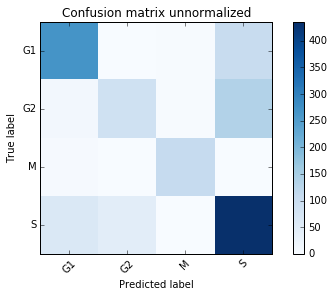

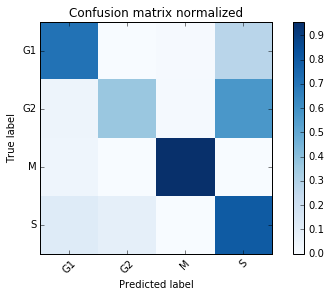

In [5]:
if H2b.Var_missing[0] in H2b.train.columns:
    H2b.missing_features_train()
if H2b.Var_missing[0] in H2b.data.columns:
    H2b.missing_features_data()
values=[100 + i*10 for i in range(30)]
model=RandomForest_Autotunner(values)

model.tunning(H2b.train[H2b.names],H2b.train["Type"],3,plot=True,fit_new_model=True)
print "training dataset: \n"
print H2b.train["Type"].value_counts()

i_=np.argmax(model.MSE)
n_tree=values[i_]
print "We now have a classifier with n=%d, with an expected accuracy of %5.3f \n" %(n_tree,max(model.MSE))

plot_matrix(model.cm,title="Confusion matrix unnormalized")
plt.show()
model.cm_normalized = model.cm.astype('float') / model.cm.sum(axis=1)[:, np.newaxis]
plot_matrix(model.cm_normalized,title="Confusion matrix normalized")
plt.show()

In [6]:
index_no_missing=H2b.data[H2b.names].dropna(axis=0, how='any').index
H2b.data.ix[index_no_missing,"Classif_1"]=model.predict(H2b.data.ix[index_no_missing,H2b.names])
H2b.update()
print "Frequency of predicted values: \n"
print H2b.data["Classif_1"].value_counts()
print "\n We were however not able to predict %d instances because of missing values" % (H2b.data.shape[0]-len(index_no_missing))

Updated member Group_of_traj
Frequency of predicted values: 

1    33747
S    31005
2     8710
M     5219
Name: Classif_1, dtype: int64

 We were however not able to predict 7 instances because of missing values


In [7]:
temp_X= H2b.data[pd.notnull(H2b.data["traj"])]["Classif_1"]

print "Frequency within trajectories: \n"
print temp_X.value_counts()

print "\n We were however not able to predict %d instances because of missing values" % (sum(pd.isnull(temp_X)))

Frequency within trajectories: 

S    13386
1    12464
2     2590
M     1374
Name: Classif_1, dtype: int64

 We were however not able to predict 0 instances because of missing values


# <a name="Normalized"></a> Normalized data set

In [8]:
num_str="0015" 
## Well name
if os.path.isfile("H2b_data_norm_mult.csv"):
    print "The file existed so I loaded it."
    H2b_n_m = Traj_data(file_name="H2b_data_norm_mult.csv",pkl_traj_file="/home/pubuntu/Documents/InternWork2/Pkl_file") 

else:    
    H2b_n_m=Traj_data(pkl_traj_file="/home/pubuntu/Documents/InternWork2/Pkl_file") 

    H2b_n_m.extracting(num_str,"both_channels_0015.hdf5",'primary') 
    ## Extracting the hdf5 file for the primary channel (H2b)
    
    H2b_n_m.add_error()
    H2b_n_m.Add_traj(normalize=True)## ,num_traj=10) ## (you can reduce the number of traj)
    ## Adding Alice's work on tracking to have trajectories

    file_loc="0015_PCNA.xml"

    H2b_n_m.label_finder(file_loc) 
    ## Finding associated labels by minimizing distance by click and distance of cell

    H2b_n_m.renaming_and_merge() 
    ## renaming the labels to have G1=="1", S=="S", G2=="2" and M=="M" 
    #This procedure may take a long time.
    
    H2b_n_m.data.to_csv('H2b_data_norm_mult.csv',index=False,header=True) 

The file existed so I loaded it.
Traj_data built
Reader constructed
Updated member Group_of_traj


In [9]:
H2b_n_m.train.ix[_rand_index_train,_rand_col]

,ls1_TAREA_sample_mean,h2_DAV,h8_2COR,ch_acd,h2_2IDM
24710,1.130319,0.000000,0.392545,0.917428,2.509619
7131,0.982243,0.997285,0.948501,1.050101,0.994499
1396,8.983968,0.000000,0.016757,1.130599,0.339042
96,9.256982,0.000000,0.013898,1.106095,0.315558
4927,8.628979,0.055405,0.010620,1.130188,0.277376


In [10]:
H2b_n_m.train.ix[_rand_index_train,info_col]

,0015_id_frame,0015_id_object,0015_line_id,0015_pos_x,0015_pos_y,traj,Type
24710,236,115,24710,691,765,27,2
7131,85,79,7131,714,725,26,M
1396,18,64,1396,432,747,NaN,S
96,1,29,96,869,443,NaN,1
4927,62,32,4927,1034,401,NaN,S


If we look at the features of a certain trajectory

In [11]:
traj=0
H2b_n_m.data.ix[H2b_n_m.data["traj"]==traj,_rand_col+[num_str+"_id_frame"]]

,ls1_TAREA_sample_mean,h2_DAV,h8_2COR,ch_acd,h2_2IDM,0015_id_frame
400,1.000000,1.000000,1.000000,1.000000,1.000000,5
473,1.125600,0.338199,0.287137,0.980047,1.153589,6
546,1.049826,0.279826,0.435582,0.994478,1.544953,7
620,1.013778,0.207225,0.547100,0.938377,1.832810,8
694,0.988896,0.044795,0.547693,0.902476,2.208685,9
771,1.052927,0.011199,0.346140,0.910890,2.292116,10
844,0.973390,0.015240,0.538868,0.932483,2.310198,11
920,1.004408,0.000000,0.565248,0.938518,2.603303,12
993,0.893759,0.004633,0.493900,0.903756,2.859318,13
1071,1.119207,0.000000,0.292455,0.919902,2.662749,14


We now have to be careful, not all the training points are part of a trajectory. So we can't compare (with all fairness) the results exposed above with the normalised version.

Updated member Group_of_traj
Updated member Group_of_traj
training dataset: 

S    217
1    199
2     56
M     36
Name: Type, dtype: int64
Processing time: 65.307783 in sec


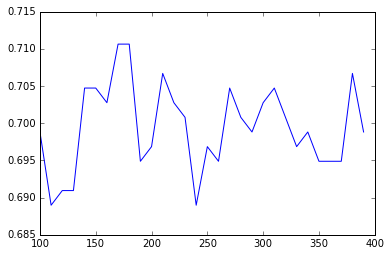

We now have a classifier with n=170, with an expected accuracy of 0.711 for the unnormalized data. 



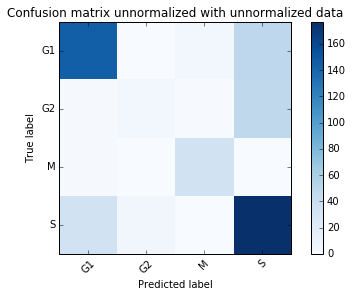

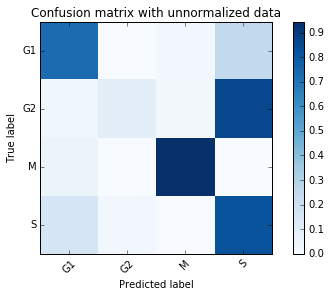

Processing time: 69.067011 in sec


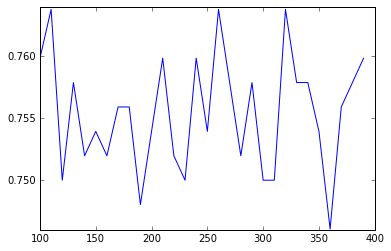

We now have a classifier with n=110, with an expected accuracy of 0.764 for the normalized data. 



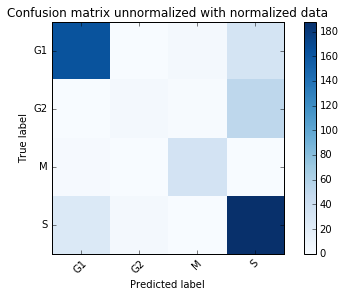

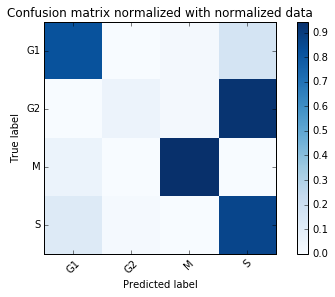

In [12]:

kfold=3

instances_to_keep=pd.notnull(H2b_n_m.data.traj)

H2b.data=H2b.data.ix[instances_to_keep,H2b.data.columns]
H2b.update()

H2b_n_m.data=H2b_n_m.data.ix[instances_to_keep,H2b_n_m.data.columns]
H2b_n_m.update()

print "training dataset: \n"
print H2b_n_m.train["Type"].value_counts()

if H2b.Var_missing[0] in H2b.train.columns:
    H2b.missing_features_train()
if H2b.Var_missing[0] in H2b.data.columns:
    H2b.missing_features_data()
values=[100 + i*10 for i in range(30)]
model_t=RandomForest_Autotunner(values)

model_t.tunning(H2b.train[H2b.names],H2b.train["Type"],kfold,plot=True,fit_new_model=True)
plt.show()

i_=np.argmax(model_t.MSE)
n_tree=values[i_]
print "We now have a classifier with n=%d, with an expected accuracy of %5.3f for the unnormalized data. \n" %(n_tree,max(model_t.MSE))

plot_matrix(model_t.cm,title="Confusion matrix unnormalized with unnormalized data")
plt.show()
model_t.cm_normalized = model_t.cm.astype('float') / model_t.cm.sum(axis=1)[:, np.newaxis]
plot_matrix(model_t.cm_normalized,title="Confusion matrix with unnormalized data")
plt.show()



if H2b_n_m.Var_missing[0] in H2b_n_m.train.columns:
    H2b_n_m.missing_features_train()
if H2b_n_m.Var_missing[0] in H2b_n_m.data.columns:
    H2b_n_m.missing_features_data()
values=[100 + i*10 for i in range(30)]
model_n_m=RandomForest_Autotunner(values)

model_n_m.tunning(H2b_n_m.train[H2b_n_m.names],H2b_n_m.train["Type"],kfold,plot=True,fit_new_model=True)
plt.show()

i_=np.argmax(model_n_m.MSE)
n_tree=values[i_]
print "We now have a classifier with n=%d, with an expected accuracy of %5.3f for the normalized data. \n" %(n_tree,max(model_n_m.MSE))


plot_matrix(model_n_m.cm,title="Confusion matrix unnormalized with normalized data")
plt.show()
model_n_m.cm_normalized = model_n_m.cm.astype('float') / model_n_m.cm.sum(axis=1)[:, np.newaxis]
plot_matrix(model_n_m.cm_normalized,title="Confusion matrix normalized with normalized data")
plt.show()

# <a name="MitoseOrNot"></a> Classifier for Mitosis or Not

In [13]:
train_file="MitoseClassif.arff"

train_1=Reader()
train_1.arrf_read(train_file)
train_1.renaming_for_mitosis()

train_1.data["label"].value_counts()

Reader constructed


O    2842
S    1293
M    1016
Name: label, dtype: int64

Processing time: 664.994825 in sec


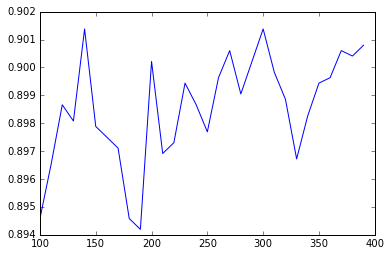

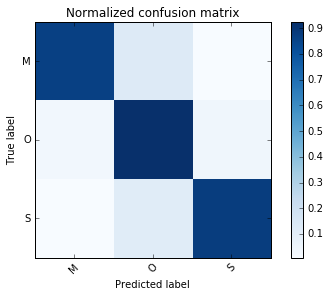

In [14]:
kfold=3

if train_1.Var_missing[0] in train_1.data.columns:
    train_1.missing_features_data()
    
values=[100 + i*10 for i in range(30)]
model_1=RandomForest_Autotunner(values)

model_1.tunning(train_1.data[train_1.names],train_1.data["label"],kfold,plot=True,fit_new_model=True)
plt.show()

model_1.cm_normalized = model_1.cm.astype('float') / model_1.cm.sum(axis=1)[:, np.newaxis]

plot_matrix(model_1.cm_normalized,title="Normalized confusion matrix",names=["M","O","S"])
plt.show()

# <a name="Fusion"></a> Predicting and regrouping the first predictor and the 3 state predictor

Because we have too few instances in phase M, we used the first classifier. This classifier has priority over the first prediction as it the H2B marker is meant to be informative about the Mitosis events.

Updated member Group_of_traj
Updated member Group_of_traj
Frequency of predicted values for the Mitosis or not classifier: 

S    14625
O    14309
M      880
Name: MitoseOrNot, dtype: int64

 We were however not able to predict 0 instances because of missing values
Updated member Group_of_traj
training dataset: 

S    217
1    199
2     56
Name: Type, dtype: int64
Processing time: 63.186140 in sec


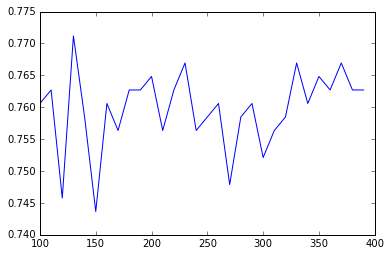

We now have a classifier with n=130, with an expected accuracy of 0.771 for the normalized data. 



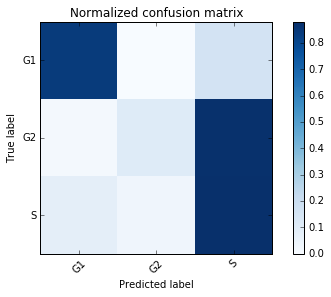

Frequency of predicted values for the 3 state classifier: 

1    15890
S    12586
2     1338
Name: 3State, dtype: int64


In [15]:
## To reduce computation and none useless things, we remove instances that do not belong to trajectories.

index_traj=pd.notnull(H2b_n_m.data["traj"])
H2b_n_m.data=H2b_n_m.data.ix[index_traj,H2b_n_m.data.columns]
H2b.data=H2b.data.ix[index_traj,H2b.data.columns]

H2b_n_m.update()
H2b.update()
## Predicting model 1

index_no_missing=H2b_n_m.data[H2b_n_m.names].dropna(axis=0, how='any').index
H2b_n_m.data.ix[index_no_missing,"MitoseOrNot"]=model_1.predict(H2b.data.ix[index_no_missing,train_1.names]) 
## Carefull, we put the unnormalized data in the above prediction.

print "Frequency of predicted values for the Mitosis or not classifier: \n"
print H2b_n_m.data["MitoseOrNot"].value_counts()
print "\n We were however not able to predict %d instances because of missing values" % (H2b_n_m.data.shape[0]-len(index_no_missing))

H2b_n_m.data

H2b_n_m.update()

##We have to retrain the model for the normalized version as this one was trained with the class M

index_no_M=H2b_n_m.data["Type"]!="M"

print "training dataset: \n"
print H2b_n_m.train.ix[index_no_M,"Type"].value_counts()


values=[100 + i*10 for i in range(30)]
model_n_m=RandomForest_Autotunner(values)

model_n_m.tunning(H2b_n_m.train.ix[index_no_M,H2b_n_m.names],H2b_n_m.train.ix[index_no_M,"Type"],kfold,plot=True,fit_new_model=True)
plt.show()

i_=np.argmax(model_n_m.MSE)
n_tree=values[i_]
print "We now have a classifier with n=%d, with an expected accuracy of %5.3f for the normalized data. \n" %(n_tree,max(model_n_m.MSE))

model_n_m.cm_normalized = model_n_m.cm.astype('float') / model_n_m.cm.sum(axis=1)[:, np.newaxis]
plot_matrix(model_n_m.cm_normalized,title="Normalized confusion matrix",names=["G1","G2","S"])
plt.show()

H2b_n_m.data.ix[index_no_missing,"3State"]=model_n_m.predict(H2b_n_m.data.ix[index_no_missing,H2b_n_m.names])
print "Frequency of predicted values for the 3 state classifier: \n"
print H2b_n_m.data.ix[index_no_missing,"3State"].value_counts()




In [16]:
### Giving priority to the first classif...
def f(value_1,value_2):
    if value_1=="M":
        return(value_1)
    else:
        return(value_2)
H2b_n_m.data["Pred_Fusion"]=H2b_n_m.data.apply(lambda r: f(r["MitoseOrNot"],r["3State"]),axis=1)

print "Frequency of predicted values for the 4 state classifier: \n"
print H2b_n_m.data.ix[index_no_missing,"Pred_Fusion"].value_counts()
H2b_n_m.update()

Frequency of predicted values for the 4 state classifier: 

1    15013
S    12583
2     1338
M      880
Name: Pred_Fusion, dtype: int64
Updated member Group_of_traj


# Hidden Markov Model

In [17]:
##First we are going to seperate beginning M's and ending M's
for i in range(len(H2b_n_m.trajectories)):
    new_obs=np.array(H2b_n_m.data.ix[H2b_n_m.data["traj"]==i,"Pred_Fusion"])
    n_obs=len(new_obs)
    for j in range(n_obs/2):
        if new_obs[j]=='M':
            new_obs[j]='B'  #Beginning
    H2b_n_m.data.ix[H2b_n_m.data["traj"]==i,"Pred_Fusion"]=new_obs
H2b_n_m.data.ix[H2b_n_m.data["Pred_Fusion"]=='M',"Pred_Fusion"]='E' #Ending


* What should we put as a emission state probability matrix?

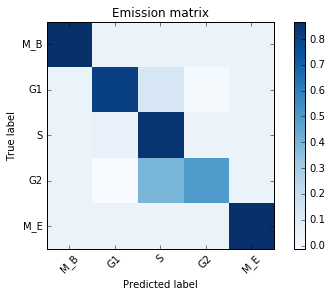

ERROR: Line magic function `%Rpush` not found.
ERROR: Line magic function `%Rpush` not found.


In [22]:
X3=model_n_m.cm_normalized
X3=np.array([X3[0],X3[2],X3[1]])
X3=X3.T
X3=np.array([X3[0],X3[2],X3[1]])
X3=X3.T

EmissionMat=np.zeros(shape=(5,5))
EmissionMat[0,0]=model_1.cm_normalized[0,0]
EmissionMat[4,4]=model_1.cm_normalized[0,0]
EmissionMat[1:5,0]=(1-model_1.cm_normalized[0,0])/3
EmissionMat[0:4,4]=(1-model_1.cm_normalized[0,0])/3

### Bricolage

EmissionMat[1:4,1:4]=X3
EmissionMat[1:4,1:3]+=-EmissionMat[3,0]*2/3

### On modifie car la diag n'est pas assez bonne...
EmissionMat[3,2:4]=[0.4,0.5]

EmissionMat[0,1:4]=sum(model_1.cm_normalized[0,1:3])/3
EmissionMat[4,1:4]=sum(model_1.cm_normalized[0,1:3])/3

plot_matrix(EmissionMat,title="Emission matrix",names=["M_B","G1","S","G2","M_E"])
plt.show()

H2b_n_m.data=H2b_n_m.data.sort_values(['traj', num_str+"_id_frame"], ascending=[1, 1])

data=H2b_n_m.data.ix[pd.notnull(H2b_n_m.data["traj"]),["traj","Pred_Fusion"]]


data.ix[data.Pred_Fusion=='2',"Pred_Fusion"]="4"
data.ix[data.Pred_Fusion=='1',"Pred_Fusion"]="2"
data.ix[data.Pred_Fusion=='B',"Pred_Fusion"]="1"
data.ix[data.Pred_Fusion=='E',"Pred_Fusion"]="5"
data.ix[data.Pred_Fusion=='S',"Pred_Fusion"]="3"

%Rpush EmissionMat
%Rpush data 